# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (SentiWS) most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, SentiWS (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11420
EM converged at iteration 80, llf=-11165, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-11433
EM converged at iteration 79, llf=-11178, convergence criterion=9.9644e-07 < tolerance=1e-06
EM start iterations, llf=-11486
EM converged at iteration 79, llf=-11228, convergence criterion=9.83e-07 < tolerance=1e-06
EM start iterations, llf=-11493
EM converged at iteration 79, llf=-11235, convergence criterion=9.8228e-07 < tolerance=1e-06
EM start iterations, llf=-11555
EM converged at iteration 79, llf=-11292, convergence criterion=9.8595e-07 < tolerance=1e-06
EM start iterations, llf=-11563
EM converged at iteration 79, llf=-11299, convergence criterion=9.8491e-07 < tolerance=1e-06
EM start iterations, llf=-11617
EM converged at iteration 79, llf=-11354, convergence criterion=9.9409e-07 < tolerance=1e-06
EM start iterations, llf=-11617
EM converged at iteration 79, llf=-11354, convergence criterion=9.9409e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13022
EM converged at iteration 55, llf=-12824, convergence criterion=9.8607e-07 < tolerance=1e-06
EM start iterations, llf=-13084
EM converged at iteration 52, llf=-12896, convergence criterion=9.8165e-07 < tolerance=1e-06
EM start iterations, llf=-13090
EM converged at iteration 53, llf=-12900, convergence criterion=9.8787e-07 < tolerance=1e-06
EM start iterations, llf=-13142
EM converged at iteration 54, llf=-12947, convergence criterion=9.6723e-07 < tolerance=1e-06
EM start iterations, llf=-13142
EM converged at iteration 54, llf=-12947, convergence criterion=9.6723e-07 < tolerance=1e-06
EM start iterations, llf=-13154
EM converged at iteration 54, llf=-12961, convergence criterion=9.716e-07 < tolerance=1e-06
EM start iterations, llf=-13204
EM converged at iteration 53, llf=-13013, convergence criterion=9.8565e-07 < tolerance=1e-06
EM start iterations, llf=-13209
EM converged at iteration 53, llf=-13017, convergence criterion=9.9747e-07 < tolerance=1e-06
E

EM start iterations, llf=-14709
EM converged at iteration 54, llf=-14498, convergence criterion=9.7018e-07 < tolerance=1e-06
EM start iterations, llf=-14709
EM converged at iteration 54, llf=-14498, convergence criterion=9.7018e-07 < tolerance=1e-06
EM start iterations, llf=-14718
EM converged at iteration 54, llf=-14507, convergence criterion=9.695e-07 < tolerance=1e-06
EM start iterations, llf=-14770
EM converged at iteration 54, llf=-14559, convergence criterion=9.6577e-07 < tolerance=1e-06
EM start iterations, llf=-14781
EM converged at iteration 53, llf=-14570, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-14830
EM converged at iteration 53, llf=-14619, convergence criterion=9.9511e-07 < tolerance=1e-06
EM start iterations, llf=-14837
EM converged at iteration 53, llf=-14626, convergence criterion=9.9435e-07 < tolerance=1e-06
EM start iterations, llf=-14884
EM converged at iteration 54, llf=-14671, convergence criterion=9.7315e-07 < tolerance=1e-06
E

EM start iterations, llf=-16378
EM converged at iteration 46, llf=-16138, convergence criterion=9.6115e-07 < tolerance=1e-06
EM start iterations, llf=-16383
EM converged at iteration 46, llf=-16143, convergence criterion=9.6054e-07 < tolerance=1e-06
EM start iterations, llf=-16435
EM converged at iteration 45, llf=-16195, convergence criterion=9.9085e-07 < tolerance=1e-06
EM start iterations, llf=-16442
EM converged at iteration 45, llf=-16201, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-16497
EM converged at iteration 45, llf=-16256, convergence criterion=9.816e-07 < tolerance=1e-06
EM start iterations, llf=-16497
EM converged at iteration 45, llf=-16256, convergence criterion=9.816e-07 < tolerance=1e-06
EM start iterations, llf=-16506
EM converged at iteration 45, llf=-16266, convergence criterion=9.7442e-07 < tolerance=1e-06
EM start iterations, llf=-16557
EM converged at iteration 45, llf=-16317, convergence criterion=9.724e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-17859
EM converged at iteration 36, llf=-17608, convergence criterion=9.7939e-07 < tolerance=1e-06
EM start iterations, llf=-17917
EM converged at iteration 36, llf=-17665, convergence criterion=9.8793e-07 < tolerance=1e-06
EM start iterations, llf=-17917
EM converged at iteration 36, llf=-17665, convergence criterion=9.8793e-07 < tolerance=1e-06
EM start iterations, llf=-17922
EM converged at iteration 36, llf=-17670, convergence criterion=9.8806e-07 < tolerance=1e-06
EM start iterations, llf=-17974
EM converged at iteration 37, llf=-17721, convergence criterion=9.4673e-07 < tolerance=1e-06
EM start iterations, llf=-17981
EM converged at iteration 36, llf=-17728, convergence criterion=9.9917e-07 < tolerance=1e-06
EM start iterations, llf=-18037
EM converged at iteration 37, llf=-17782, convergence criterion=9.6009e-07 < tolerance=1e-06
EM start iterations, llf=-18044
EM converged at iteration 37, llf=-17789, convergence criterion=9.6009e-07 < tolerance=1e-06


EM converged at iteration 115, llf=-11546, convergence criterion=9.9801e-07 < tolerance=1e-06
EM start iterations, llf=-11837
EM iteration 100, llf=-11559, convergence criterion=1.2921e-06
EM converged at iteration 116, llf=-11559, convergence criterion=9.9756e-07 < tolerance=1e-06
EM start iterations, llf=-11876
EM converged at iteration 97, llf=-11593, convergence criterion=9.9915e-07 < tolerance=1e-06
EM start iterations, llf=-11887
EM converged at iteration 97, llf=-11605, convergence criterion=9.9088e-07 < tolerance=1e-06
EM start iterations, llf=-11971
EM converged at iteration 96, llf=-11693, convergence criterion=9.9037e-07 < tolerance=1e-06
EM start iterations, llf=-11971
EM converged at iteration 96, llf=-11693, convergence criterion=9.9037e-07 < tolerance=1e-06
EM start iterations, llf=-11954
EM converged at iteration 96, llf=-11673, convergence criterion=9.9828e-07 < tolerance=1e-06
EM start iterations, llf=-12034
EM converged at iteration 95, llf=-11767, convergence criter

EM start iterations, llf=-13340
EM converged at iteration 72, llf=-13147, convergence criterion=9.9797e-07 < tolerance=1e-06
EM start iterations, llf=-13384
EM converged at iteration 76, llf=-13193, convergence criterion=9.8127e-07 < tolerance=1e-06
EM start iterations, llf=-13391
EM converged at iteration 72, llf=-13198, convergence criterion=9.7994e-07 < tolerance=1e-06
EM start iterations, llf=-13435
EM converged at iteration 71, llf=-13240, convergence criterion=9.9633e-07 < tolerance=1e-06
EM start iterations, llf=-13447
EM converged at iteration 74, llf=-13252, convergence criterion=9.8435e-07 < tolerance=1e-06
EM start iterations, llf=-13492
EM converged at iteration 79, llf=-13302, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-13492
EM converged at iteration 79, llf=-13302, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-13504
EM converged at iteration 76, llf=-13312, convergence criterion=9.8173e-07 < tolerance=1e-06


EM start iterations, llf=-15001
EM converged at iteration 65, llf=-14781, convergence criterion=9.9497e-07 < tolerance=1e-06
EM start iterations, llf=-15013
EM converged at iteration 66, llf=-14794, convergence criterion=9.8266e-07 < tolerance=1e-06
EM start iterations, llf=-15068
EM converged at iteration 64, llf=-14847, convergence criterion=9.9509e-07 < tolerance=1e-06
EM start iterations, llf=-15068
EM converged at iteration 64, llf=-14847, convergence criterion=9.9509e-07 < tolerance=1e-06
EM start iterations, llf=-15079
EM converged at iteration 64, llf=-14860, convergence criterion=9.9739e-07 < tolerance=1e-06
EM start iterations, llf=-15132
EM converged at iteration 64, llf=-14912, convergence criterion=9.9669e-07 < tolerance=1e-06
EM start iterations, llf=-15142
EM converged at iteration 64, llf=-14920, convergence criterion=9.9708e-07 < tolerance=1e-06
EM start iterations, llf=-15197
EM converged at iteration 65, llf=-14978, convergence criterion=9.8311e-07 < tolerance=1e-06


EM start iterations, llf=-16686
EM converged at iteration 51, llf=-16447, convergence criterion=9.9355e-07 < tolerance=1e-06
EM start iterations, llf=-16695
EM converged at iteration 51, llf=-16458, convergence criterion=9.8682e-07 < tolerance=1e-06
EM start iterations, llf=-16748
EM converged at iteration 51, llf=-16511, convergence criterion=9.7091e-07 < tolerance=1e-06
EM start iterations, llf=-16754
EM converged at iteration 50, llf=-16517, convergence criterion=9.973e-07 < tolerance=1e-06
EM start iterations, llf=-16806
EM converged at iteration 49, llf=-16568, convergence criterion=9.7678e-07 < tolerance=1e-06
EM start iterations, llf=-16815
EM converged at iteration 49, llf=-16577, convergence criterion=9.7518e-07 < tolerance=1e-06
EM start iterations, llf=-16873
EM converged at iteration 47, llf=-16636, convergence criterion=9.7651e-07 < tolerance=1e-06
EM start iterations, llf=-16873
EM converged at iteration 47, llf=-16636, convergence criterion=9.7651e-07 < tolerance=1e-06
E

EM start iterations, llf=-18165
EM converged at iteration 41, llf=-17902, convergence criterion=9.882e-07 < tolerance=1e-06
EM start iterations, llf=-18211
EM converged at iteration 41, llf=-17947, convergence criterion=9.7804e-07 < tolerance=1e-06
EM start iterations, llf=-18222
EM converged at iteration 41, llf=-17957, convergence criterion=9.7672e-07 < tolerance=1e-06
EM start iterations, llf=-18267
EM converged at iteration 41, llf=-18002, convergence criterion=9.8969e-07 < tolerance=1e-06
EM start iterations, llf=-18267
EM converged at iteration 41, llf=-18002, convergence criterion=9.8969e-07 < tolerance=1e-06
EM start iterations, llf=-18277
EM converged at iteration 41, llf=-18014, convergence criterion=9.8572e-07 < tolerance=1e-06
EM start iterations, llf=-18323
EM converged at iteration 42, llf=-18058, convergence criterion=9.533e-07 < tolerance=1e-06
EM start iterations, llf=-18330
EM converged at iteration 41, llf=-18065, convergence criterion=9.9811e-07 < tolerance=1e-06
EM

EM converged at iteration 102, llf=-11837, convergence criterion=9.9081e-07 < tolerance=1e-06
EM start iterations, llf=-12071
EM iteration 100, llf=-11836, convergence criterion=1.105e-06
EM converged at iteration 106, llf=-11836, convergence criterion=9.828e-07 < tolerance=1e-06
EM start iterations, llf=-12071
EM iteration 100, llf=-11836, convergence criterion=1.105e-06
EM converged at iteration 106, llf=-11836, convergence criterion=9.828e-07 < tolerance=1e-06
EM start iterations, llf=-12078
EM iteration 100, llf=-11854, convergence criterion=1.1207e-06
EM converged at iteration 106, llf=-11853, convergence criterion=9.9661e-07 < tolerance=1e-06
EM start iterations, llf=-12098
EM iteration 100, llf=-11880, convergence criterion=1.0671e-06
EM converged at iteration 104, llf=-11880, convergence criterion=9.8462e-07 < tolerance=1e-06
EM start iterations, llf=-12105
EM iteration 100, llf=-11892, convergence criterion=1.0677e-06
EM converged at iteration 104, llf=-11891, convergence crit

EM converged at iteration 75, llf=-13336, convergence criterion=9.7824e-07 < tolerance=1e-06
EM start iterations, llf=-13538
EM converged at iteration 74, llf=-13337, convergence criterion=9.8198e-07 < tolerance=1e-06
EM start iterations, llf=-13571
EM converged at iteration 73, llf=-13362, convergence criterion=9.839e-07 < tolerance=1e-06
EM start iterations, llf=-13576
EM converged at iteration 74, llf=-13374, convergence criterion=9.825e-07 < tolerance=1e-06
EM start iterations, llf=-13618
EM converged at iteration 74, llf=-13425, convergence criterion=9.8531e-07 < tolerance=1e-06
EM start iterations, llf=-13618
EM converged at iteration 74, llf=-13425, convergence criterion=9.8531e-07 < tolerance=1e-06
EM start iterations, llf=-13629
EM converged at iteration 74, llf=-13436, convergence criterion=9.8423e-07 < tolerance=1e-06
EM start iterations, llf=-13680
EM converged at iteration 74, llf=-13486, convergence criterion=9.8382e-07 < tolerance=1e-06
EM start iterations, llf=-13688
EM

EM start iterations, llf=-15192
EM converged at iteration 70, llf=-14976, convergence criterion=9.9929e-07 < tolerance=1e-06
EM start iterations, llf=-15245
EM converged at iteration 69, llf=-15025, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-15245
EM converged at iteration 69, llf=-15025, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-15253
EM converged at iteration 69, llf=-15033, convergence criterion=9.9182e-07 < tolerance=1e-06
EM start iterations, llf=-15305
EM converged at iteration 70, llf=-15083, convergence criterion=9.9989e-07 < tolerance=1e-06
EM start iterations, llf=-15308
EM converged at iteration 71, llf=-15084, convergence criterion=9.8241e-07 < tolerance=1e-06
EM start iterations, llf=-15366
EM converged at iteration 67, llf=-15142, convergence criterion=9.9985e-07 < tolerance=1e-06
EM start iterations, llf=-15371
EM converged at iteration 67, llf=-15146, convergence criterion=9.9637e-07 < tolerance=1e-06


EM start iterations, llf=-16872
EM converged at iteration 56, llf=-16640, convergence criterion=9.7813e-07 < tolerance=1e-06
EM start iterations, llf=-16918
EM converged at iteration 53, llf=-16687, convergence criterion=9.7397e-07 < tolerance=1e-06
EM start iterations, llf=-16924
EM converged at iteration 53, llf=-16693, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-16974
EM converged at iteration 52, llf=-16742, convergence criterion=9.8559e-07 < tolerance=1e-06
EM start iterations, llf=-16982
EM converged at iteration 52, llf=-16749, convergence criterion=9.8275e-07 < tolerance=1e-06
EM start iterations, llf=-17028
EM converged at iteration 52, llf=-16795, convergence criterion=9.8137e-07 < tolerance=1e-06
EM start iterations, llf=-17028
EM converged at iteration 52, llf=-16795, convergence criterion=9.8137e-07 < tolerance=1e-06
EM start iterations, llf=-17048
EM converged at iteration 52, llf=-16814, convergence criterion=9.8349e-07 < tolerance=1e-06


EM start iterations, llf=-18370
EM converged at iteration 47, llf=-18106, convergence criterion=9.8376e-07 < tolerance=1e-06
EM start iterations, llf=-18380
EM converged at iteration 47, llf=-18118, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-18427
EM converged at iteration 47, llf=-18166, convergence criterion=9.7203e-07 < tolerance=1e-06
EM start iterations, llf=-18427
EM converged at iteration 47, llf=-18166, convergence criterion=9.7203e-07 < tolerance=1e-06
EM start iterations, llf=-18435
EM converged at iteration 47, llf=-18175, convergence criterion=9.7097e-07 < tolerance=1e-06
EM start iterations, llf=-18492
EM converged at iteration 47, llf=-18232, convergence criterion=9.6177e-07 < tolerance=1e-06
EM start iterations, llf=-18500
EM converged at iteration 47, llf=-18239, convergence criterion=9.6074e-07 < tolerance=1e-06
EM start iterations, llf=-18552
EM converged at iteration 47, llf=-18290, convergence criterion=9.782e-07 < tolerance=1e-06
E

EM start iterations, llf=-11772
EM converged at iteration 51, llf=-11610, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-11772
EM converged at iteration 51, llf=-11610, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-11773
EM converged at iteration 53, llf=-11612, convergence criterion=9.6226e-07 < tolerance=1e-06
EM start iterations, llf=-11807
EM converged at iteration 55, llf=-11649, convergence criterion=9.7374e-07 < tolerance=1e-06
EM start iterations, llf=-11817
EM converged at iteration 54, llf=-11658, convergence criterion=9.725e-07 < tolerance=1e-06
EM start iterations, llf=-11868
EM converged at iteration 47, llf=-11712, convergence criterion=9.595e-07 < tolerance=1e-06
EM start iterations, llf=-11883
EM converged at iteration 46, llf=-11726, convergence criterion=9.8458e-07 < tolerance=1e-06
EM start iterations, llf=-11922
EM converged at iteration 47, llf=-11765, convergence criterion=9.73e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-13346
EM converged at iteration 46, llf=-13176, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-13351
EM converged at iteration 46, llf=-13183, convergence criterion=9.7318e-07 < tolerance=1e-06
EM start iterations, llf=-13406
EM converged at iteration 45, llf=-13236, convergence criterion=9.8804e-07 < tolerance=1e-06
EM start iterations, llf=-13414
EM converged at iteration 45, llf=-13246, convergence criterion=9.8999e-07 < tolerance=1e-06
EM start iterations, llf=-13464
EM converged at iteration 45, llf=-13294, convergence criterion=9.5636e-07 < tolerance=1e-06
EM start iterations, llf=-13464
EM converged at iteration 45, llf=-13294, convergence criterion=9.5636e-07 < tolerance=1e-06
EM start iterations, llf=-13470
EM converged at iteration 45, llf=-13302, convergence criterion=9.6178e-07 < tolerance=1e-06
EM start iterations, llf=-13523
EM converged at iteration 45, llf=-13354, convergence criterion=9.6613e-07 < tolerance=1e-06


EM start iterations, llf=-14970
EM converged at iteration 43, llf=-14796, convergence criterion=9.655e-07 < tolerance=1e-06
EM start iterations, llf=-15025
EM converged at iteration 43, llf=-14850, convergence criterion=9.7024e-07 < tolerance=1e-06
EM start iterations, llf=-15025
EM converged at iteration 43, llf=-14850, convergence criterion=9.7024e-07 < tolerance=1e-06
EM start iterations, llf=-15034
EM converged at iteration 43, llf=-14860, convergence criterion=9.6783e-07 < tolerance=1e-06
EM start iterations, llf=-15082
EM converged at iteration 43, llf=-14908, convergence criterion=9.724e-07 < tolerance=1e-06
EM start iterations, llf=-15091
EM converged at iteration 43, llf=-14916, convergence criterion=9.6953e-07 < tolerance=1e-06
EM start iterations, llf=-15134
EM converged at iteration 43, llf=-14958, convergence criterion=9.6965e-07 < tolerance=1e-06
EM start iterations, llf=-15141
EM converged at iteration 43, llf=-14966, convergence criterion=9.696e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16571
EM converged at iteration 36, llf=-16393, convergence criterion=9.5263e-07 < tolerance=1e-06
EM start iterations, llf=-16620
EM converged at iteration 35, llf=-16440, convergence criterion=9.8624e-07 < tolerance=1e-06
EM start iterations, llf=-16627
EM converged at iteration 35, llf=-16447, convergence criterion=9.8327e-07 < tolerance=1e-06
EM start iterations, llf=-16675
EM converged at iteration 35, llf=-16494, convergence criterion=9.6731e-07 < tolerance=1e-06
EM start iterations, llf=-16683
EM converged at iteration 35, llf=-16502, convergence criterion=9.6934e-07 < tolerance=1e-06
EM start iterations, llf=-16736
EM converged at iteration 35, llf=-16554, convergence criterion=9.625e-07 < tolerance=1e-06
EM start iterations, llf=-16736
EM converged at iteration 35, llf=-16554, convergence criterion=9.625e-07 < tolerance=1e-06
EM start iterations, llf=-16742
EM converged at iteration 35, llf=-16561, convergence criterion=9.7548e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17743
EM converged at iteration 33, llf=-17563, convergence criterion=9.9261e-07 < tolerance=1e-06
EM start iterations, llf=-17747
EM converged at iteration 33, llf=-17567, convergence criterion=9.9214e-07 < tolerance=1e-06
EM start iterations, llf=-17801
EM converged at iteration 33, llf=-17621, convergence criterion=9.8134e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 1 estimated in 1:51:21.193524.
EM start iterations, llf=-10934
EM converged at iteration 75, llf=-10774, convergence criterion=9.973e-07 < tolerance=1e-06
EM start iterations, llf=-10946
EM converged at iteration 76, llf=-10786, convergence criterion=9.7849e-07 < tolerance=1e-06
EM start iterations, llf=-10999
EM converged at iteration 73, llf=-10839, convergence criterion=9.8833e-07 < tolerance=1e-06
EM start iterations, llf=-11007
EM converged at iteration 73, llf=-10847, convergence criterion=9.8298e-07 < tolerance=1e-06
EM start iterations, llf=-11062
EM converged at 

EM start iterations, llf=-12298
EM converged at iteration 53, llf=-12142, convergence criterion=9.7675e-07 < tolerance=1e-06
EM start iterations, llf=-12298
EM converged at iteration 53, llf=-12142, convergence criterion=9.7675e-07 < tolerance=1e-06
EM start iterations, llf=-12311
EM converged at iteration 53, llf=-12154, convergence criterion=9.8133e-07 < tolerance=1e-06
EM start iterations, llf=-12345
EM converged at iteration 55, llf=-12188, convergence criterion=9.7543e-07 < tolerance=1e-06
EM start iterations, llf=-12352
EM converged at iteration 55, llf=-12192, convergence criterion=9.9334e-07 < tolerance=1e-06
EM start iterations, llf=-12412
EM converged at iteration 55, llf=-12245, convergence criterion=9.9746e-07 < tolerance=1e-06
EM start iterations, llf=-12416
EM converged at iteration 55, llf=-12252, convergence criterion=9.8345e-07 < tolerance=1e-06
EM start iterations, llf=-12457
EM converged at iteration 53, llf=-12294, convergence criterion=9.8229e-07 < tolerance=1e-06


EM start iterations, llf=-13855
EM converged at iteration 45, llf=-13686, convergence criterion=9.722e-07 < tolerance=1e-06
EM start iterations, llf=-13866
EM converged at iteration 45, llf=-13695, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-13912
EM converged at iteration 47, llf=-13741, convergence criterion=9.7264e-07 < tolerance=1e-06
EM start iterations, llf=-13920
EM converged at iteration 47, llf=-13749, convergence criterion=9.7429e-07 < tolerance=1e-06
EM start iterations, llf=-13970
EM converged at iteration 47, llf=-13798, convergence criterion=9.7603e-07 < tolerance=1e-06
EM start iterations, llf=-13970
EM converged at iteration 47, llf=-13798, convergence criterion=9.7603e-07 < tolerance=1e-06
EM start iterations, llf=-13977
EM converged at iteration 47, llf=-13806, convergence criterion=9.7215e-07 < tolerance=1e-06
EM start iterations, llf=-14026
EM converged at iteration 46, llf=-13854, convergence criterion=9.8845e-07 < tolerance=1e-06
E

EM start iterations, llf=-15468
EM converged at iteration 40, llf=-15291, convergence criterion=9.9107e-07 < tolerance=1e-06
EM start iterations, llf=-15511
EM converged at iteration 40, llf=-15334, convergence criterion=9.9837e-07 < tolerance=1e-06
EM start iterations, llf=-15511
EM converged at iteration 40, llf=-15334, convergence criterion=9.9837e-07 < tolerance=1e-06
EM start iterations, llf=-15525
EM converged at iteration 40, llf=-15347, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-15580
EM converged at iteration 40, llf=-15403, convergence criterion=9.9895e-07 < tolerance=1e-06
EM start iterations, llf=-15582
EM converged at iteration 41, llf=-15406, convergence criterion=9.6979e-07 < tolerance=1e-06
EM start iterations, llf=-15634
EM converged at iteration 40, llf=-15457, convergence criterion=9.7972e-07 < tolerance=1e-06
EM start iterations, llf=-15640
EM converged at iteration 40, llf=-15464, convergence criterion=9.7481e-07 < tolerance=1e-06


EM start iterations, llf=-16875
EM converged at iteration 32, llf=-16696, convergence criterion=9.5102e-07 < tolerance=1e-06
EM start iterations, llf=-16921
EM converged at iteration 32, llf=-16742, convergence criterion=9.4617e-07 < tolerance=1e-06
EM start iterations, llf=-16935
EM converged at iteration 32, llf=-16755, convergence criterion=9.4603e-07 < tolerance=1e-06
EM start iterations, llf=-16989
EM converged at iteration 31, llf=-16808, convergence criterion=9.9545e-07 < tolerance=1e-06
EM start iterations, llf=-16995
EM converged at iteration 31, llf=-16813, convergence criterion=9.9187e-07 < tolerance=1e-06
EM start iterations, llf=-17049
EM converged at iteration 31, llf=-16868, convergence criterion=9.9455e-07 < tolerance=1e-06
EM start iterations, llf=-17049
EM converged at iteration 31, llf=-16868, convergence criterion=9.9455e-07 < tolerance=1e-06
EM start iterations, llf=-17054
EM converged at iteration 31, llf=-16873, convergence criterion=9.897e-07 < tolerance=1e-06
E

EM start iterations, llf=-11336
EM converged at iteration 82, llf=-11171, convergence criterion=9.8339e-07 < tolerance=1e-06
EM start iterations, llf=-11373
EM converged at iteration 82, llf=-11209, convergence criterion=9.8151e-07 < tolerance=1e-06
EM start iterations, llf=-11376
EM converged at iteration 87, llf=-11211, convergence criterion=9.8297e-07 < tolerance=1e-06
EM start iterations, llf=-11446
EM converged at iteration 88, llf=-11282, convergence criterion=9.9707e-07 < tolerance=1e-06
EM start iterations, llf=-11446
EM converged at iteration 88, llf=-11282, convergence criterion=9.9707e-07 < tolerance=1e-06
EM start iterations, llf=-11459
EM converged at iteration 85, llf=-11296, convergence criterion=9.8091e-07 < tolerance=1e-06
EM start iterations, llf=-11553
EM converged at iteration 77, llf=-11397, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-11539
EM converged at iteration 86, llf=-11383, convergence criterion=9.8773e-07 < tolerance=1e-06


EM start iterations, llf=-12783
EM converged at iteration 74, llf=-12614, convergence criterion=9.8269e-07 < tolerance=1e-06
EM start iterations, llf=-12783
EM converged at iteration 74, llf=-12614, convergence criterion=9.8269e-07 < tolerance=1e-06
EM start iterations, llf=-12792
EM converged at iteration 74, llf=-12626, convergence criterion=9.8802e-07 < tolerance=1e-06
EM start iterations, llf=-12834
EM converged at iteration 75, llf=-12667, convergence criterion=9.9983e-07 < tolerance=1e-06
EM start iterations, llf=-12842
EM converged at iteration 76, llf=-12675, convergence criterion=9.9208e-07 < tolerance=1e-06
EM start iterations, llf=-12881
EM converged at iteration 76, llf=-12713, convergence criterion=9.8976e-07 < tolerance=1e-06
EM start iterations, llf=-12873
EM converged at iteration 75, llf=-12710, convergence criterion=9.8636e-07 < tolerance=1e-06
EM start iterations, llf=-12912
EM converged at iteration 73, llf=-12747, convergence criterion=9.8733e-07 < tolerance=1e-06


EM start iterations, llf=-14371
EM converged at iteration 66, llf=-14199, convergence criterion=9.9364e-07 < tolerance=1e-06
EM start iterations, llf=-14380
EM converged at iteration 66, llf=-14208, convergence criterion=9.9611e-07 < tolerance=1e-06
EM start iterations, llf=-14433
EM converged at iteration 65, llf=-14261, convergence criterion=9.8921e-07 < tolerance=1e-06
EM start iterations, llf=-14439
EM converged at iteration 65, llf=-14268, convergence criterion=9.9464e-07 < tolerance=1e-06
EM start iterations, llf=-14484
EM converged at iteration 65, llf=-14315, convergence criterion=9.8785e-07 < tolerance=1e-06
EM start iterations, llf=-14484
EM converged at iteration 65, llf=-14315, convergence criterion=9.8785e-07 < tolerance=1e-06
EM start iterations, llf=-14497
EM converged at iteration 65, llf=-14326, convergence criterion=9.8963e-07 < tolerance=1e-06
EM start iterations, llf=-14552
EM converged at iteration 67, llf=-14379, convergence criterion=9.8216e-07 < tolerance=1e-06


EM start iterations, llf=-15979
EM converged at iteration 63, llf=-15798, convergence criterion=9.9779e-07 < tolerance=1e-06
EM start iterations, llf=-16033
EM converged at iteration 63, llf=-15854, convergence criterion=9.8033e-07 < tolerance=1e-06
EM start iterations, llf=-16033
EM converged at iteration 63, llf=-15854, convergence criterion=9.8033e-07 < tolerance=1e-06
EM start iterations, llf=-16042
EM converged at iteration 63, llf=-15861, convergence criterion=9.7863e-07 < tolerance=1e-06
EM start iterations, llf=-16086
EM converged at iteration 59, llf=-15906, convergence criterion=9.9899e-07 < tolerance=1e-06
EM start iterations, llf=-16090
EM converged at iteration 59, llf=-15910, convergence criterion=9.982e-07 < tolerance=1e-06
EM start iterations, llf=-16139
EM converged at iteration 59, llf=-15961, convergence criterion=9.782e-07 < tolerance=1e-06
EM start iterations, llf=-16149
EM converged at iteration 59, llf=-15970, convergence criterion=9.811e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-17393
EM converged at iteration 51, llf=-17210, convergence criterion=9.9448e-07 < tolerance=1e-06
EM start iterations, llf=-17439
EM converged at iteration 51, llf=-17255, convergence criterion=9.9748e-07 < tolerance=1e-06
EM start iterations, llf=-17447
EM converged at iteration 52, llf=-17262, convergence criterion=9.7274e-07 < tolerance=1e-06
EM start iterations, llf=-17491
EM converged at iteration 52, llf=-17307, convergence criterion=9.8369e-07 < tolerance=1e-06
EM start iterations, llf=-17498
EM converged at iteration 52, llf=-17314, convergence criterion=9.7566e-07 < tolerance=1e-06
EM start iterations, llf=-17541
EM converged at iteration 52, llf=-17356, convergence criterion=9.7488e-07 < tolerance=1e-06
EM start iterations, llf=-17541
EM converged at iteration 52, llf=-17356, convergence criterion=9.7488e-07 < tolerance=1e-06
EM start iterations, llf=-17546
EM converged at iteration 52, llf=-17361, convergence criterion=9.8992e-07 < tolerance=1e-06


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


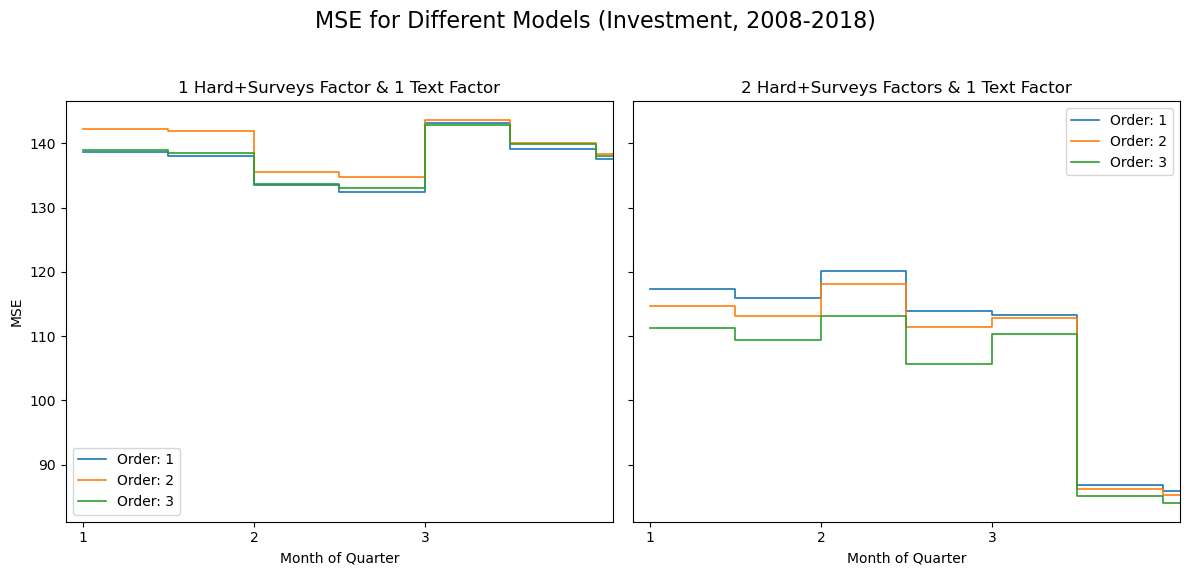

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


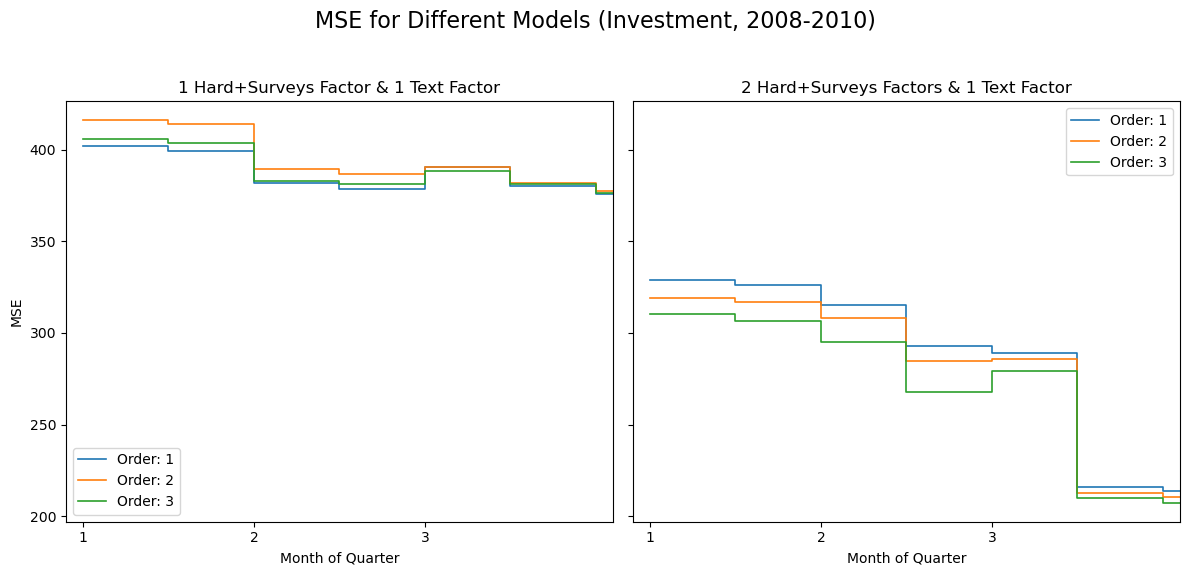

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


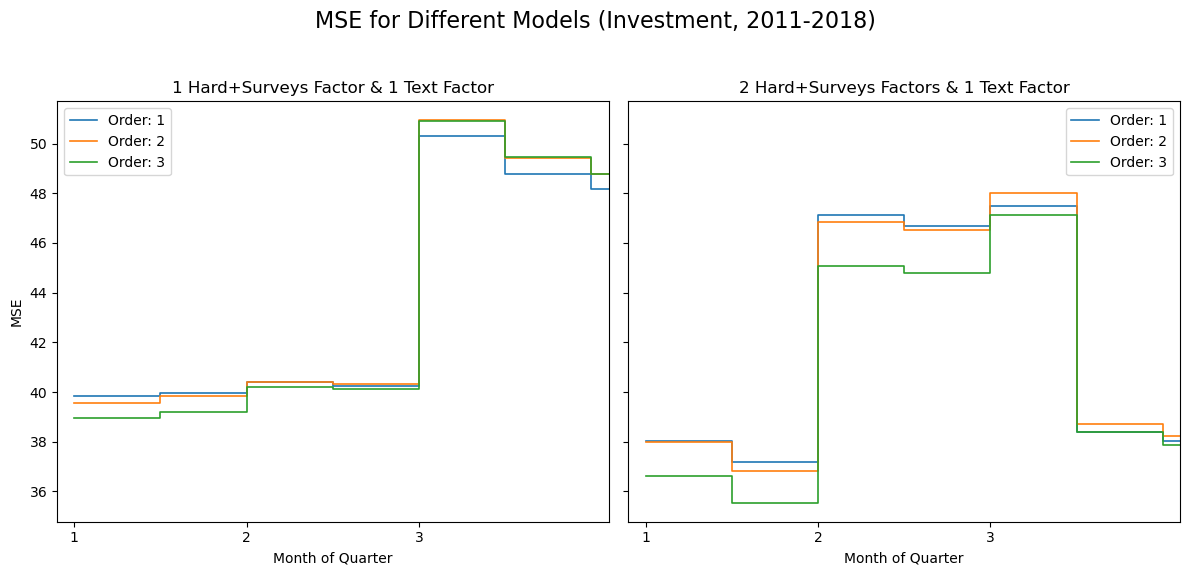

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


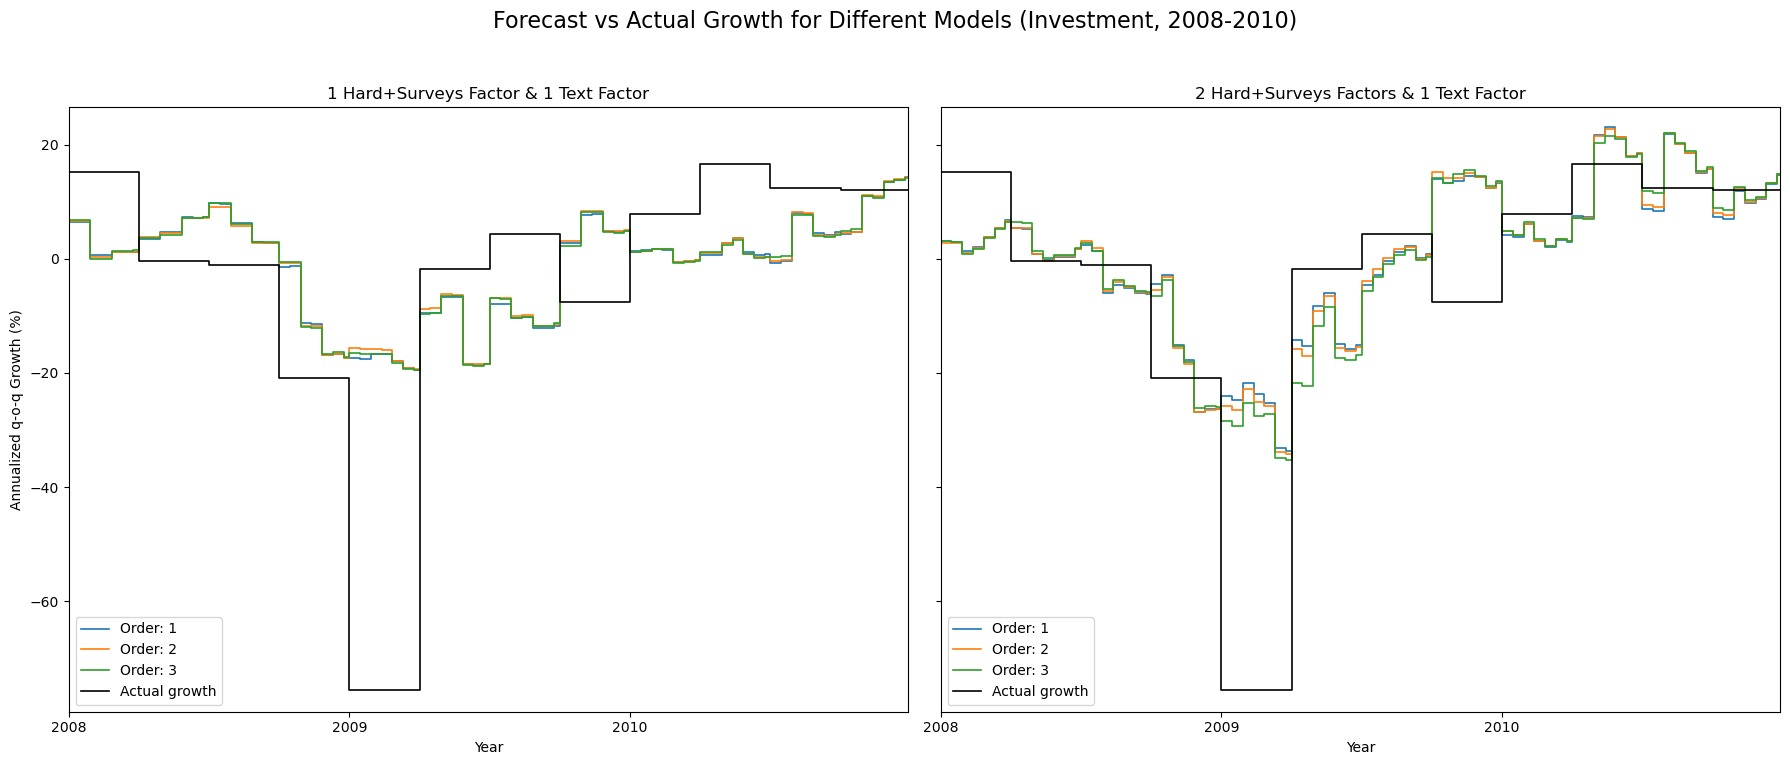

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


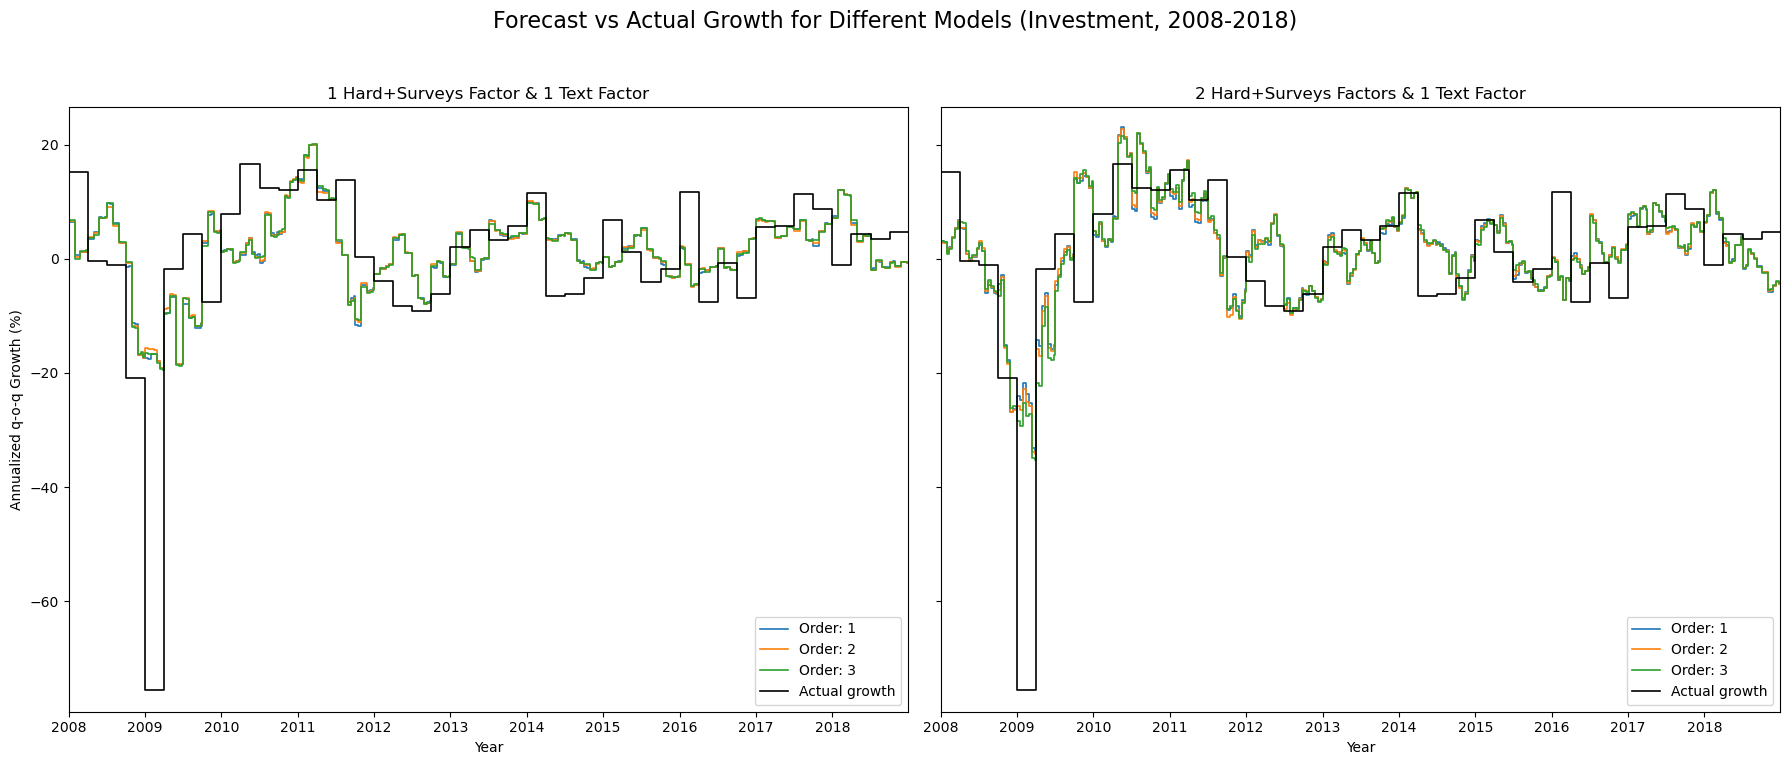

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


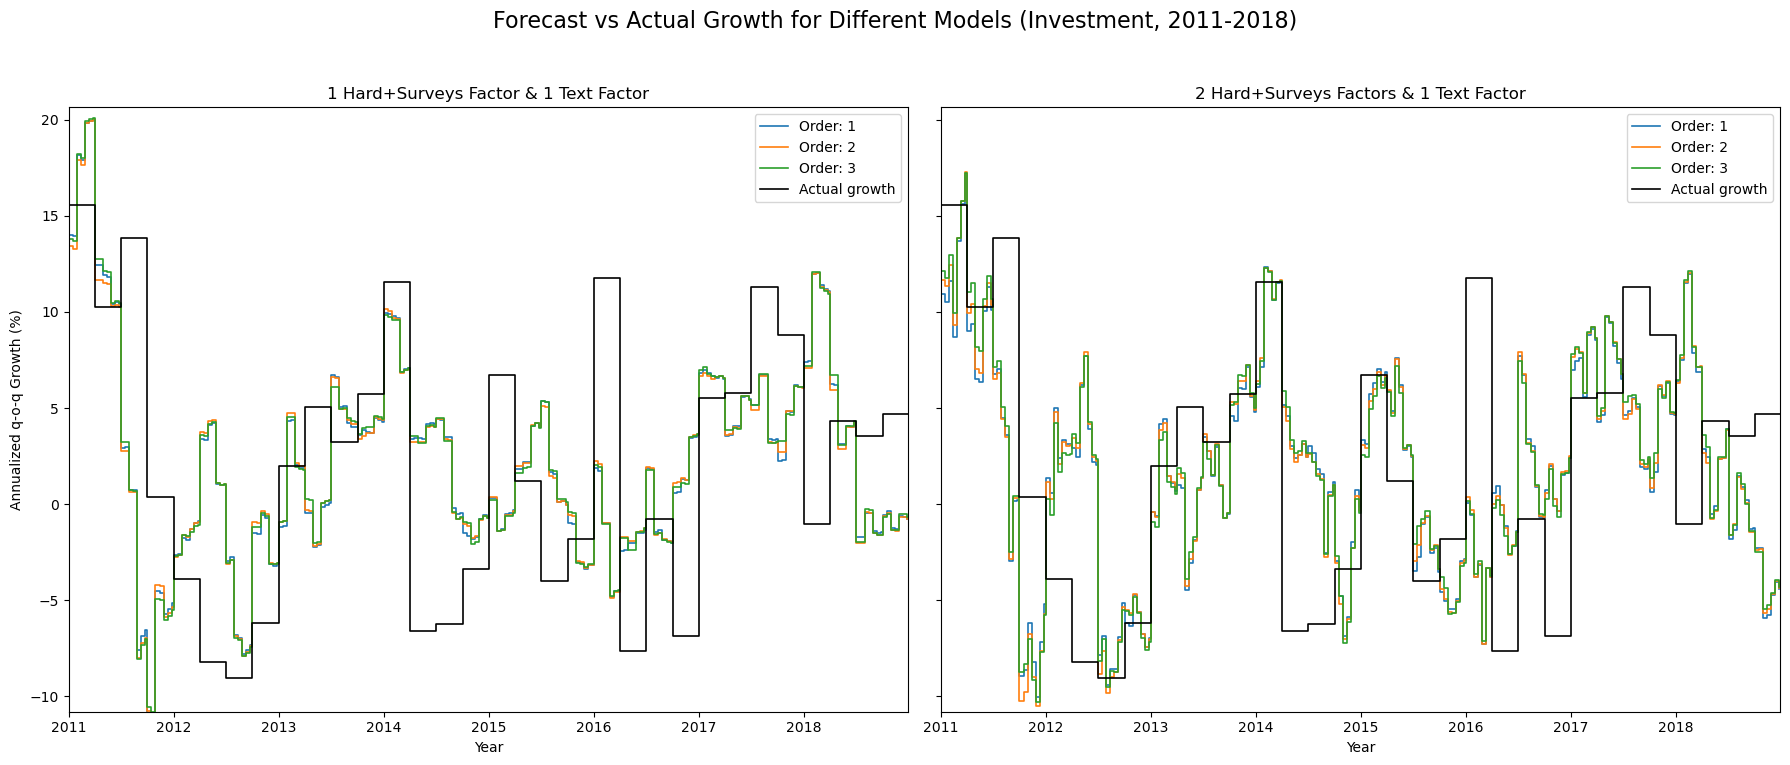

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()